# Elastic Net

Fit leave-one-out elastic net regressions for age prediction.


In [1]:
from utils.variation import var_comp
from utils.misc import extract_number, mae
import pandas as pd
import numpy as np
from utils.enet import loo_fit

## Data Loading

In [2]:
gene_expressions = pd.read_csv("data/train_data.csv", index_col=0)
gene_expressions_mat = gene_expressions.to_numpy()
genenames = np.array(gene_expressions.index.tolist())
samples = gene_expressions.columns.tolist()

# extract ages
ages = np.array([extract_number(timestring) for timestring in samples])
unique_ages=np.unique(ages)


# retain genes that are present in all samples
prevalence = np.mean(gene_expressions_mat > 0, axis=1)
subset_gene_id = np.where(prevalence == 1)[0]
subset_genenames = genenames[subset_gene_id]
gene_expressions = gene_expressions.loc[subset_genenames, :]
gene_expressions_mat = gene_expressions_mat[subset_gene_id, :]

# get log expressions
log_gene_expressions = np.log(gene_expressions)
log_gene_expressions_mat = np.log(gene_expressions_mat)

# transpose count tables to samples by genes
gene_expressions = gene_expressions.T
gene_expressions_mat = gene_expressions_mat.T
log_gene_expressions = log_gene_expressions.T
log_gene_expressions_mat = log_gene_expressions_mat.T

# get rankings of samples for each gene expression
gene_expressions_rank = log_gene_expressions.rank()

## Elastic Net Regressions

In [3]:
from utils.enet import fit_enet, loo_fit

In [4]:
def mae_tune(input_expression, labels, label_min=2, label_max=50,
             log=False, rank=False, numgenes=np.array([50, 100, 200, 400, 600, 800, 1000]),
             lambdas=np.array([0.2, 0.5, 1, 2])):

    expressions = input_expression.copy()
    targets = labels.copy()
    mask = np.logical_and(targets >= label_min, targets <= label_max)
    expressions = expressions.loc[mask, :]
    targets = targets[mask]

    if log:
        expressions = np.log(expressions)
    if rank:
        expressions = expressions.rank()

    # calculate sorted R^2
    varcomp_sorted = var_comp(geneexp_df=expressions, groups=targets)
    varcomp_sorted = varcomp_sorted.sort_values(by='R2', ascending=False)
    sorted_genes = varcomp_sorted.index.tolist()

    results_df = pd.DataFrame({"NumGene": numgenes,
                            "MAE": 0})

    best_mae = 40
    best_predictions = np.zeros_like(targets)

    for j in range(len(results_df)):
        num_genes = results_df["NumGene"][j]
        selected_genes = sorted_genes[0:num_genes]

        output = loo_fit(X=expressions.loc[:, selected_genes].to_numpy(), Y=targets,
                         lambdas=lambdas)
        latest_mae = mae(output["Truth"], output["Predicted"], type="mean")
        if latest_mae < best_mae:
            best_mae = latest_mae
            best_predictions = output["Predicted"]

        results_df["MAE"][j] = latest_mae


    prediction_df = pd.DataFrame({"Truth": targets,
                                  "Predicted": best_predictions})

    return results_df, prediction_df

In [79]:
filters = np.logical_and(ages >= 4, ages <= 23)

In [86]:
performance_raw, predictions_raw = mae_tune(input_expression=gene_expressions.loc[filters, :], labels=ages[filters].astype(np.float32), log=False, rank=False,
                                    numgenes=np.array([50, 100, 200, 400, 600, 800, 1000, 2000]), lambdas=np.array([0.2]))

In [87]:
performance_raw

,NumGene,MAE
0,50,2.906071
1,100,2.648207
2,200,2.598979
3,400,2.923048
4,600,2.811168
5,800,2.787507
6,1000,3.015955
7,2000,3.220299


In [90]:
performance_log, predictions_log = mae_tune(input_expression=gene_expressions.loc[filters, :], labels=ages[filters].astype(np.float32), log=True, rank=False,
                                    numgenes=np.array([50, 100, 200, 400, 600, 800]), lambdas=np.array([0.2]))

In [92]:
performance_log

,NumGene,MAE
0,50,2.681396
1,100,2.534513
2,200,2.776431
3,400,2.746229
4,600,2.789758
5,800,2.961030


In [96]:
performance_rank, predictions_rank = mae_tune(input_expression=gene_expressions.loc[filters, :], labels=ages[filters].astype(np.float32), log=True, rank=True,
                                    numgenes=np.array([50, 100, 200, 400, 600, 800, 1000, 1200, 4000]), lambdas=np.array([0.2]))

In [97]:
performance_rank

,NumGene,MAE
0,50,3.210343
1,100,2.741801
2,200,2.590929
3,400,2.596944
4,600,2.492447
5,800,2.500007
6,1000,2.292118
7,1200,2.442491
8,4000,2.358304


First let's try training range of 2-15.

In [10]:
train_range_2_15 = unique_ages[np.logical_and(unique_ages >= 2, unique_ages <= 15)]
result_2_15 = loo_fit(X=loggeneexp, Y=ages, y_range=train_range_2_15, test_indices=test_indices, lambdas=penalties)

Then let's try range of 6-15.

In [11]:
train_range_6_15 = unique_ages[np.logical_and(unique_ages >= 6, unique_ages <= 15)]
result_6_15 = loo_fit(X=loggeneexp, Y=ages, y_range=train_range_6_15, test_indices=test_indices, lambdas=penalties)

Then let's try range of 2-18.

In [12]:
train_range_2_18 = unique_ages[np.logical_and(unique_ages >= 2, unique_ages <= 18)]
result_2_18 = loo_fit(X=loggeneexp, Y=ages, y_range=train_range_2_18, test_indices=test_indices, lambdas=penalties)

Then let's try range of 6-18.

In [13]:
train_range_6_18 = unique_ages[np.logical_and(unique_ages >= 6, unique_ages <= 18)]
result_6_18 = loo_fit(X=loggeneexp, Y=ages, y_range=train_range_6_18, test_indices=test_indices, lambdas=penalties)

Then let's try range of 2-23.

In [14]:
train_range_2_23 = unique_ages[np.logical_and(unique_ages >= 2, unique_ages <= 23)]
result_2_23 = loo_fit(X=loggeneexp, Y=ages, y_range=train_range_2_23, test_indices=test_indices, lambdas=penalties)

Then let's try range of 6-23.

In [15]:
train_range_6_23 = unique_ages[np.logical_and(unique_ages >= 6, unique_ages <= 23)]
result_6_23 = loo_fit(X=loggeneexp, Y=ages, y_range=train_range_6_23, test_indices=test_indices, lambdas=penalties)

Visualize the predicted value VS true value.

In [42]:
def summary_performance(pred_df):

    pred_df["difference"] = np.abs(pred_df["Predicted"] - pred_df["Truth"])
    diff_mean = pred_df.groupby('Truth')["difference"].mean()

    return pred_df, pd.DataFrame(diff_mean)


In [48]:
df_2_15 = result_2_15[0]
df_2_15, diff_2_15 = summary_performance(df_2_15)
df_6_15 = result_6_15[0]
df_6_15, diff_6_15 = summary_performance(df_6_15)
df_2_18 = result_2_18[0]
df_2_18, diff_2_18 = summary_performance(df_2_18)
df_6_18 = result_6_18[0]
df_6_18, diff_6_18 = summary_performance(df_6_18)
df_2_23 = result_2_23[0]
df_2_23, diff_2_23 = summary_performance(df_2_23)
df_6_23 = result_6_23[0]
df_6_23, diff_6_23 = summary_performance(df_6_23)

In [49]:
df_2_23

,Truth,Predicted,difference
0,2,10.576881,8.576881
1,2,9.472953,7.472953
2,2,11.889274,9.889274
3,2,15.831340,13.831340
4,4,6.185568,2.185568
5,4,3.555956,0.444044
6,4,6.854347,2.854347
7,6,12.309721,6.309721
8,6,13.137057,7.137057
9,6,15.527770,9.527770


First plot

In [55]:
import matplotlib.pyplot as plt
color_gray="#808080"
color_red="#db382c"
color_green="#2f7028"
color_brown="#665223"
color_blue="#344885"
color_magenta="#b538b3"
all_colors = [color_gray, color_red, color_green, color_brown, color_blue, color_magenta]

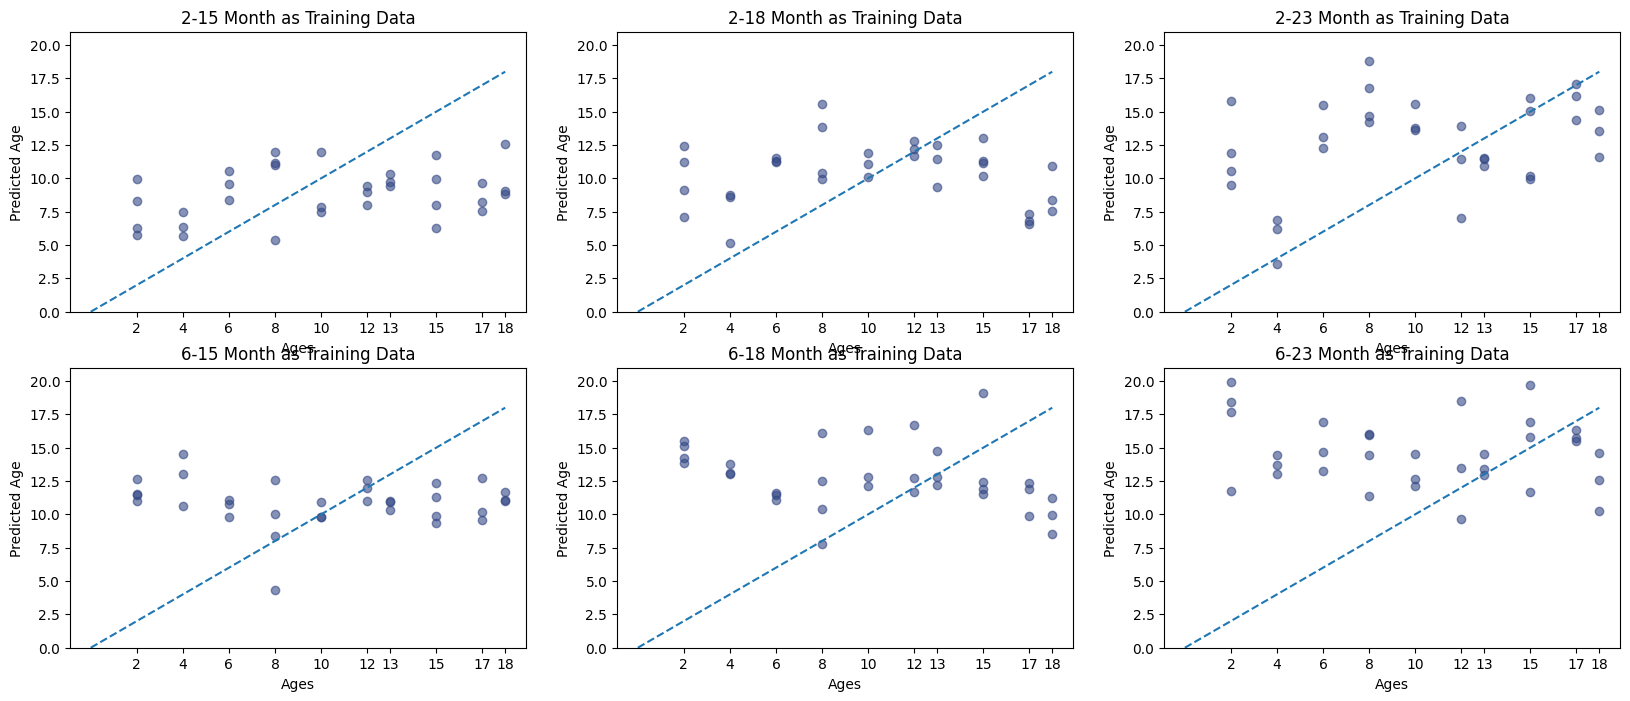

In [54]:
fig1, ax1 = plt.subplots(figsize=(20, 8), nrows=2, ncols=3)
ax1[0,0].scatter(df_2_15["Truth"], df_2_15["Predicted"], color=color_blue, alpha=0.6)
ax1[0,0].set_xlabel('Ages')
ax1[0,0].set_xticks(np.unique(test_truth))
ax1[0,0].set_ylabel("Predicted Age")
ax1[0,0].set_title("2-15 Month as Training Data")
ax1[0,0].set_ylim(0, 21)
ax1[0,0].plot([0,18], [0, 18], linestyle='--')

ax1[0,1].scatter(df_2_18["Truth"], df_2_18["Predicted"], color=color_blue, alpha=0.6)
ax1[0,1].set_xlabel('Ages')
ax1[0,1].set_xticks(np.unique(test_truth))
ax1[0,1].set_ylabel("Predicted Age")
ax1[0,1].set_title("2-18 Month as Training Data")
ax1[0,1].set_ylim(0, 21)
ax1[0,1].plot([0,18], [0,18], linestyle='--')

ax1[0,2].scatter(df_2_23["Truth"], df_2_23["Predicted"], color=color_blue, alpha=0.6)
ax1[0,2].set_xlabel('Ages')
ax1[0,2].set_xticks(np.unique(test_truth))
ax1[0,2].set_ylabel("Predicted Age")
ax1[0,2].set_title("2-23 Month as Training Data")
ax1[0,2].set_ylim(0, 21)
ax1[0,2].plot([0,18], [0,18], linestyle='--')

ax1[1,0].scatter(df_6_15["Truth"], df_6_15["Predicted"], color=color_blue, alpha=0.6)
ax1[1,0].set_xlabel('Ages')
ax1[1,0].set_xticks(np.unique(test_truth))
ax1[1,0].set_ylabel("Predicted Age")
ax1[1,0].set_title("6-15 Month as Training Data")
ax1[1,0].set_ylim(0, 21)
ax1[1,0].plot([0,18], [0,18], linestyle='--')


ax1[1,1].scatter(df_6_18["Truth"], df_6_18["Predicted"], color=color_blue, alpha=0.6)
ax1[1,1].set_xlabel('Ages')
ax1[1,1].set_xticks(np.unique(test_truth))
ax1[1,1].set_ylabel("Predicted Age")
ax1[1,1].set_title("6-18 Month as Training Data")
ax1[1,1].set_ylim(0, 21)
ax1[1,1].plot([0,18], [0,18], linestyle='--')


ax1[1,2].scatter(df_6_23["Truth"], df_6_23["Predicted"], color=color_blue, alpha=0.6)
ax1[1,2].set_xlabel('Ages')
ax1[1,2].set_xticks(np.unique(test_truth))
ax1[1,2].set_ylabel("Predicted Age")
ax1[1,2].set_title("6-23 Month as Training Data")
ax1[1,2].set_ylim(0, 21)
ax1[1,2].plot([0,18], [0,18], linestyle='--')

fig1.savefig("enet/enet_trainrange_1.png", bbox_inches='tight', dpi=400)


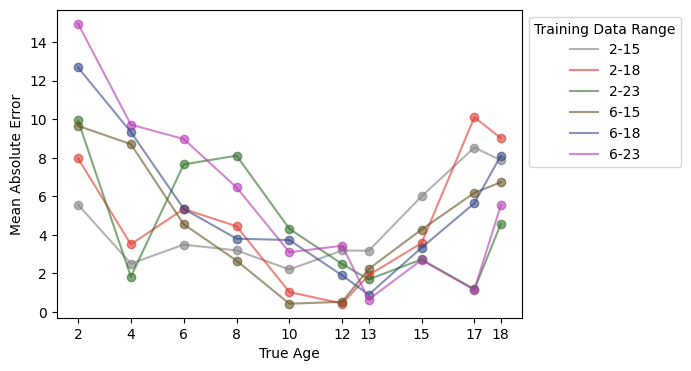

In [59]:
fig2, ax2 = plt.subplots(figsize=(6, 4))
unique_ages = diff_2_15.index.tolist()

ax2.plot(unique_ages, diff_2_15["difference"].tolist(), label="2-15", color=all_colors[0], alpha=0.6)
ax2.scatter(unique_ages, diff_2_15["difference"].tolist(), color=all_colors[0], alpha=0.6)
ax2.plot(unique_ages, diff_2_18["difference"].tolist(), label="2-18", color=all_colors[1], alpha=0.6)
ax2.scatter(unique_ages, diff_2_18["difference"].tolist(), color=all_colors[1], alpha=0.6)
ax2.plot(unique_ages, diff_2_23["difference"].tolist(), label="2-23", color=all_colors[2], alpha=0.6)
ax2.scatter(unique_ages, diff_2_23["difference"].tolist(), color=all_colors[2], alpha=0.6)
ax2.plot(unique_ages, diff_6_15["difference"].tolist(), label="6-15", color=all_colors[3], alpha=0.6)
ax2.scatter(unique_ages, diff_6_15["difference"].tolist(), color=all_colors[3], alpha=0.6)
ax2.plot(unique_ages, diff_6_18["difference"].tolist(), label="6-18", color=all_colors[4], alpha=0.6)
ax2.scatter(unique_ages, diff_6_18["difference"].tolist(), color=all_colors[4], alpha=0.6)
ax2.plot(unique_ages, diff_6_23["difference"].tolist(), label="6-23", color=all_colors[5], alpha=0.6)
ax2.scatter(unique_ages, diff_6_23["difference"].tolist(), color=all_colors[5], alpha=0.6)

ax2.set_xlabel('True Age')
ax2.set_ylabel('Mean Absolute Error')
ax2.set_xticks(unique_ages)
ax2.legend(title="Training Data Range", loc="upper left", bbox_to_anchor=(1,1))


fig2.savefig("enet/enet_trainrange_1_MAE.png", bbox_inches='tight', dpi=400)

In [60]:
import pickle
results = {"2_15": result_2_15,
           "2_18": result_2_18,
           "2-23": result_2_23,
           "6-15": result_6_15,
           "6-18": result_6_18,
           "6-23": result_6_23}

with open("enet/training_range/results.pkl", "wb+") as f:
    pickle.dump(results, f)

In [10]:
import pickle

In [11]:
with open("enet/training_range/results.pkl", "rb") as f:
    results = pickle.load(f)

In [13]:
results.keys()

dict_keys(['2_15', '2_18', '2-23', '6-15', '6-18', '6-23'])

In [15]:
coef_2_15 = results["2_15"][1]
coef_2_18 = results["2_18"][1]
coef_2_23 = results["2-23"][1]
coef_6_15 = results["6-15"][1]
coef_6_18 = results["6-18"][1]
coef_6_23 = results["6-23"][1]

In [31]:
def num_predictors(coef_mat, feature_names, train_range="2-15"):

    num_selected = np.sum(coef_mat !=0, axis=1)
    df_num_selected = pd.DataFrame({"NumVar": num_selected})
    df_num_selected["Range"] = train_range

    selection_frequency = np.mean(coef_mat!=0, axis=0)
    feature_frequency = pd.DataFrame({"Feature": feature_names, "Frequency": selection_frequency})
    feature_frequency = feature_frequency.sort_values(by='Frequency', ascending=False)

    return df_num_selected, feature_frequency


In [38]:
models_2_15, features_2_15 = num_predictors(coef_mat=coef_2_15, feature_names=subset_genenames, train_range="2-15")
models_2_18, features_2_18 = num_predictors(coef_mat=coef_2_18, feature_names=subset_genenames, train_range="2-18")
models_2_23, features_2_23 = num_predictors(coef_mat=coef_2_23, feature_names=subset_genenames, train_range="2-23")
models_6_15, features_6_15 = num_predictors(coef_mat=coef_6_15, feature_names=subset_genenames, train_range="6-15")
models_6_18, features_6_18 = num_predictors(coef_mat=coef_6_18, feature_names=subset_genenames, train_range="6-18")
models_6_23, features_6_23 = num_predictors(coef_mat=coef_6_23, feature_names=subset_genenames, train_range="6-23")

In [39]:
models_combined = pd.concat([models_2_15, models_2_18, models_2_23,
                             models_6_15, models_6_18, models_6_23], axis=0)

In [42]:
models_combined.head()

,NumVar,Range
0,66,2-15
1,80,2-15
2,83,2-15
3,71,2-15
4,70,2-15


In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

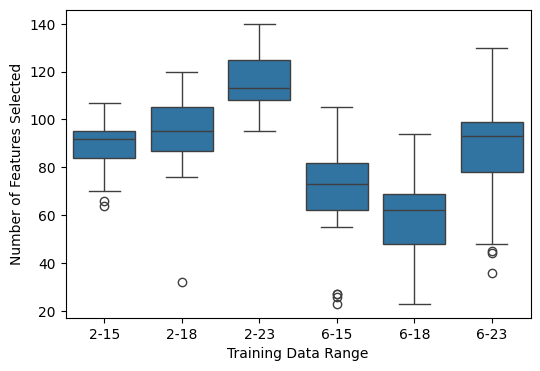

In [46]:
fig3, ax3 = plt.subplots(figsize=(6, 4))

sns.boxplot(x="Range", y="NumVar", data=models_combined, ax=ax3)
ax3.set_xlabel("Training Data Range")
ax3.set_ylabel('Number of Features Selected')

fig3.savefig("enet/enet_numvar_1.png", bbox_inches='tight', dpi=400)

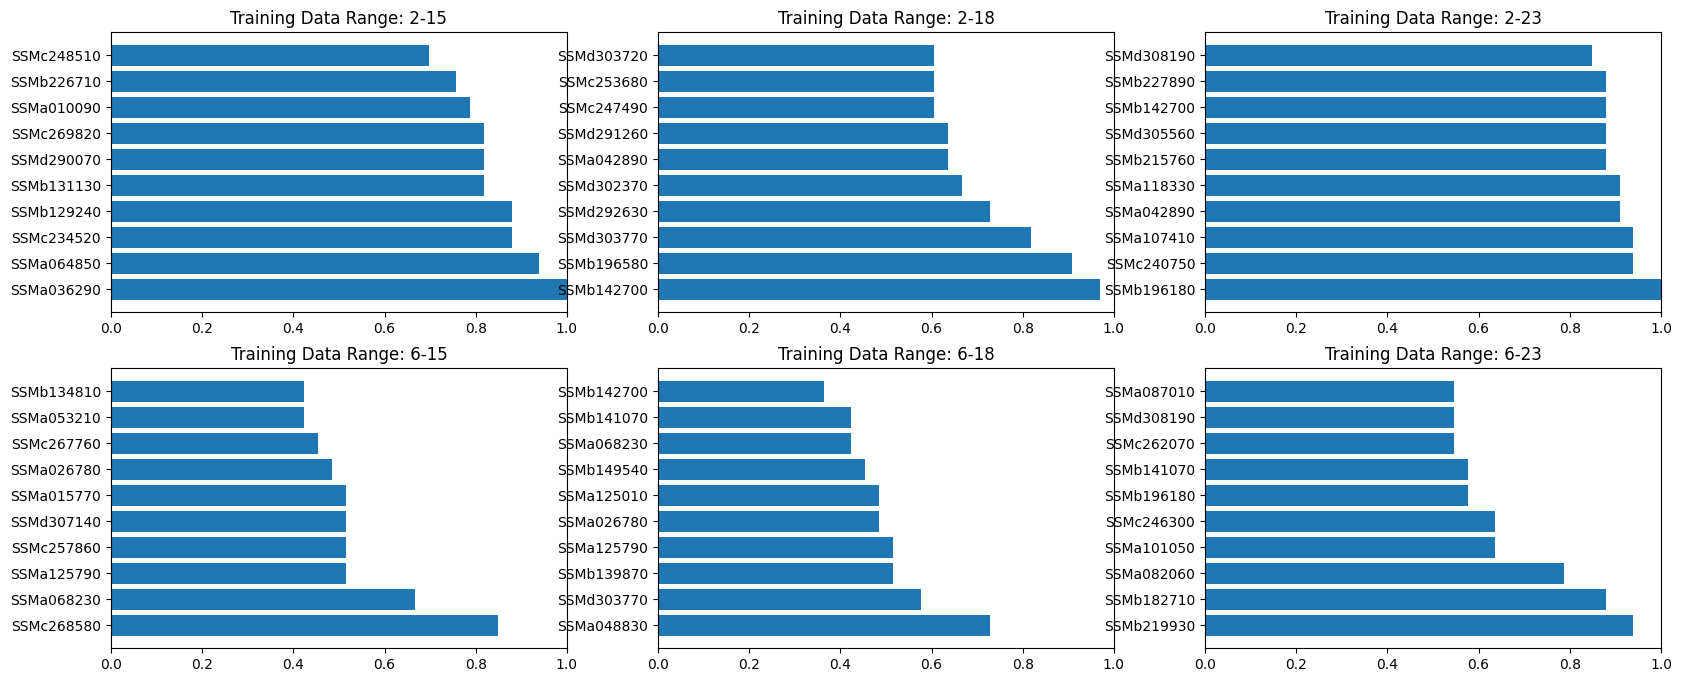

In [51]:
fig4, ax4 = plt.subplots(figsize=(20, 8), nrows=2, ncols=3)

ax4[0,0].barh(y=features_2_15["Feature"][0:10].tolist(), width=features_2_15["Frequency"][0:10].tolist())
ax4[0,0].set_xlim(0, 1)
ax4[0,0].set_title("Training Data Range: 2-15")

ax4[0,1].barh(y=features_2_18["Feature"][0:10].tolist(), width=features_2_18["Frequency"][0:10].tolist())
ax4[0,1].set_xlim(0, 1)
ax4[0,1].set_title("Training Data Range: 2-18")

ax4[0,2].barh(y=features_2_23["Feature"][0:10].tolist(), width=features_2_23["Frequency"][0:10].tolist())
ax4[0,2].set_xlim(0, 1)
ax4[0,2].set_title("Training Data Range: 2-23")

ax4[1,0].barh(y=features_6_15["Feature"][0:10].tolist(), width=features_6_15["Frequency"][0:10].tolist())
ax4[1,0].set_xlim(0, 1)
ax4[1,0].set_title("Training Data Range: 6-15")

ax4[1,1].barh(y=features_6_18["Feature"][0:10].tolist(), width=features_6_18["Frequency"][0:10].tolist())
ax4[1,1].set_xlim(0, 1)
ax4[1,1].set_title("Training Data Range: 6-18")

ax4[1,2].barh(y=features_6_23["Feature"][0:10].tolist(), width=features_6_23["Frequency"][0:10].tolist())
ax4[1,2].set_xlim(0, 1)
ax4[1,2].set_title("Training Data Range: 6-23")

fig4.savefig("enet/enet_topvar_1.png", bbox_inches='tight', dpi=400)


In [52]:
ages

array([ 2,  2,  2,  2,  4,  4,  4,  6,  6,  6,  8,  8,  8,  8, 10, 10, 10,
       12, 12, 12, 13, 13, 13, 15, 15, 15, 15, 17, 17, 17, 18, 18, 18, 21,
       21, 21, 23, 23, 23, 23, 35, 35, 36, 36, 36, 36, 36, 42, 42, 42])